In [262]:
import pandas as pd
import requests
import time
import ast
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score, log_loss, brier_score_loss
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE

In [ ]:
def fetch_and_save_adverse_events(drug_name, start_date, end_date, api_key=None, batch_size=1000, output_file='/Users/sarvenaz/Desktop/Western Uni/Summer/Project/apixaban/adverse_events_apixaban_10y_filtered_characterization_other_drugs.csv'):
    total_count = 0
    filtered_records = []
    current_start_date = start_date
    records_processed = 0

    while True:
        search_url = (f"https://api.fda.gov/drug/event.json?search=patient.drug.openfda.generic_name:{drug_name}"
                      f"+AND+receivedate:[{current_start_date}+TO+{end_date}]&limit={batch_size}&sort=receivedate:asc")
        if api_key:
            search_url += f"&api_key={api_key}"

        response = requests.get(search_url)
        if response.status_code != 200:
            print(f"Error: {response.status_code}")
            print(response.json())
            break

        data = response.json().get('results', [])
        if not data:
            break

        total_count += len(data)
        for result in data:
            if 'patient' in result and 'drug' in result['patient']:
                target_drug_present = False
                exclude_report = False
                for drug in result['patient']['drug']:
                    if drug.get('drugcharacterization') == "1":
                        if drug.get('medicinalproduct').lower() == drug_name.lower():
                            target_drug_present = True
                        else:
                            exclude_report = True
                            break
                
                if target_drug_present and not exclude_report:
                    drugs_info = []
                    for drug in result['patient']['drug']:
                        drug_info = {
                            "generic_name": drug.get("openfda", {}).get("generic_name", []),
                            "drugcharacterization": drug.get('drugcharacterization'),
                            "drugdosageform": drug.get("drugdosageform"),
                            "drugadministrationroute": drug.get("drugadministrationroute"),
                            "drugstructuredosagenumb": drug.get("drugstructuredosagenumb"),
                            "drugstructuredosageunit": drug.get("drugstructuredosageunit")
                        }
                        drugs_info.append(drug_info)

                    filtered_record = {
                        "safetyreportid": result.get("safetyreportid"),
                        "receivedate": result.get("receivedate"),
                        "patientsex": result.get("patient", {}).get("patientsex"),
                        "patientage": result.get("patient", {}).get("patientonsetage"),
                        "patientweight": result.get("patient", {}).get("patientweight"),
                        "reaction": [reaction.get("reactionmeddrapt") for reaction in result.get("patient", {}).get("reaction", [])],
                        "reactionoutcome": list(set([reaction.get("reactionoutcome") for reaction in result.get("patient", {}).get("reaction", [])])),
                        "drugs_info": drugs_info
                    }
                    filtered_records.append(filtered_record)

        records_processed += len(data)
        last_received_date = data[-1]['receivedate']

        if last_received_date >= end_date or len(data) < batch_size:
            break

        current_start_date = last_received_date

        print(f"Processed up to date: {last_received_date}, Total records processed: {records_processed}, Filtered count so far: {len(filtered_records)}")

    # Save the filtered records to a CSV file
    df = pd.json_normalize(filtered_records)
    df.to_csv(output_file, index=False)

    return len(filtered_records)

api_key = 'hbwdlSscle51ktvrowxx6soKSqjsBQS20ncj04OW'
start_date = '20140101'
end_date = '20231228'
drug_name = 'apixaban'

In [211]:
# Load the dataset
file_path = '/Users/sarvenaz/Desktop/Western Uni/Summer/Project/apixaban/apixaban_10y_filtered_characterization_other_drugs.csv'
df_10y = pd.read_csv(file_path)

df_10y.head(), df_10y.columns

(   safetyreportid  receivedate  patientsex  patientage  patientweight  \
 0         9798184     20140102         1.0        79.0           96.0   
 1         9821004     20140116         2.0        79.0           81.0   
 2         9839998     20140117         1.0        84.0           70.0   
 3         9835212     20140122         1.0        47.0            NaN   
 4         9840948     20140123         1.0        69.0           96.9   
 
                                             reaction reactionoutcome  \
 0  ['Subdural haematoma', 'Brain herniation', 'Br...          [None]   
 1               ['Blister', 'Blood blister', 'Rash']      ['1', '6']   
 2                                     ['Ecchymosis']          [None]   
 3         ['Off label use', 'Myalgia', 'Arthralgia']      ['1', '6']   
 4  ['Road traffic accident', 'Cerebral haemorrhag...          [None]   
 
                                           drugs_info  
 0  [{'generic_name': ['APIXABAN'], 'drugcharacter...  
 1

In [72]:
df_10y['reaction'] = df_10y['reaction'].str.strip("[]").str.replace("'", "").str.split(', ')
df_exploded_reaction = df_10y.explode('reaction')

# Count the frequency of each reaction
reaction_counts = df_exploded_reaction['reaction'].value_counts().head(4)
print(reaction_counts)

# Filter the dataset to keep records with at least one of the top 4 reactions
top_reactions = reaction_counts.index.tolist()

# Find records that include at least one of these reactions
df_filtered = df_exploded_reaction[df_exploded_reaction['reaction'].isin(top_reactions)]

# Group by safetyreportid to aggregate the reactions
df_grouped = df_filtered.groupby('safetyreportid').agg({
    'receivedate': 'first',
    'patientsex': 'first',
    'patientage': 'first',
    'patientweight': 'first',
    'reaction': lambda x: list(x.unique()),  # Keep all relevant reactions
    'reactionoutcome': 'first',
    'drugs_info': 'first'
}).reset_index()

df_grouped.to_csv('/Users/sarvenaz/Desktop/Western Uni/Summer/Project/New/Apixaban_fReaction.csv', index=False)

Cerebrovascular accident    3170
Thrombosis                  2451
Atrial fibrillation         2431
Cardiac disorder            2160
Name: reaction, dtype: int64


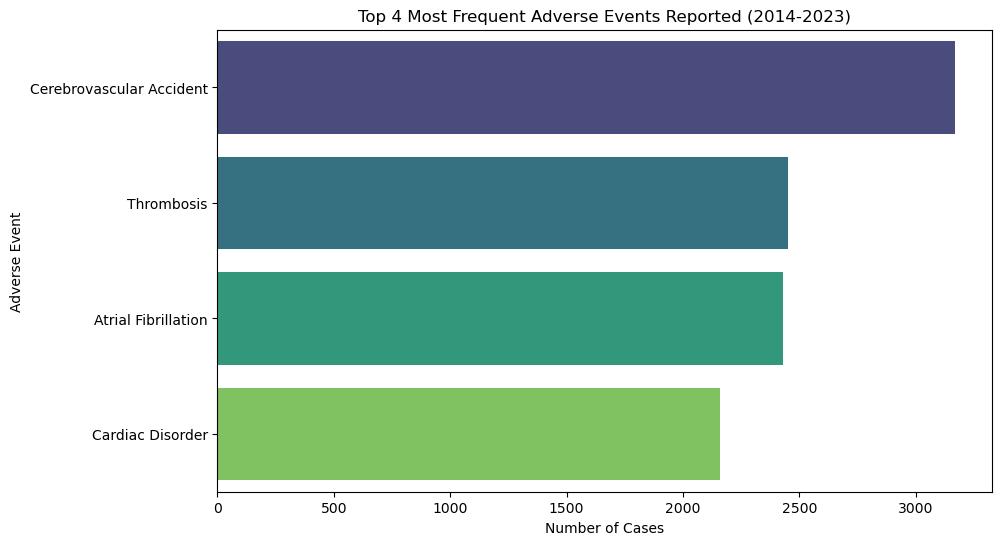

In [212]:
reaction_counts = {
    "Cerebrovascular Accident": 3170,
    "Thrombosis": 2451,
    "Atrial Fibrillation": 2431,
    "Cardiac Disorder": 2160
}

reaction_df = pd.DataFrame(list(reaction_counts.items()), columns=['Adverse Event', 'Count'])

plt.figure(figsize=(10, 6))
sns.barplot(x='Count', y='Adverse Event', data=reaction_df, palette='viridis')
plt.title('Top 4 Most Frequent Adverse Events Reported (2014-2023)')
plt.xlabel('Number of Cases')
plt.ylabel('Adverse Event')
plt.show()


In [55]:
file_path = '/Users/sarvenaz/Desktop/Western Uni/Summer/Project/apixaban/apixaban_10y_filtered_characterization_other_drugs.csv'
df = pd.read_csv(file_path)

# Function to extract the generic names of drugs from the 'drugs_info' column
def extract_generic_names(drugs_info_str):
    try:
        drugs_info = ast.literal_eval(drugs_info_str)
        generic_names = []
        for drug in drugs_info:
            names = drug.get('generic_name', [])
            generic_names.extend(names)
        return generic_names
    except (ValueError, SyntaxError):
        return []

# Apply the function to create a new column with extracted generic names
df['generic_names'] = df['drugs_info'].apply(extract_generic_names)
drugs_exploded = df.explode('generic_names')

drugs_filtered = drugs_exploded[drugs_exploded['generic_names'].str.upper() != 'APIXABAN']
drug_counts = drugs_filtered['generic_names'].value_counts().head(4)

print("Top 4 Most Repeated Drugs Taken with Apixaban in 10 Years without Reaction Filter:")
print(drug_counts.to_string())


Top 4 Most Repeated Drugs Taken with Apixaban in 10 Years without Reaction Filter:
FUROSEMIDE             818
BISOPROLOL FUMARATE    748
METOPROLOL TARTRATE    604
METOPROLOL             590


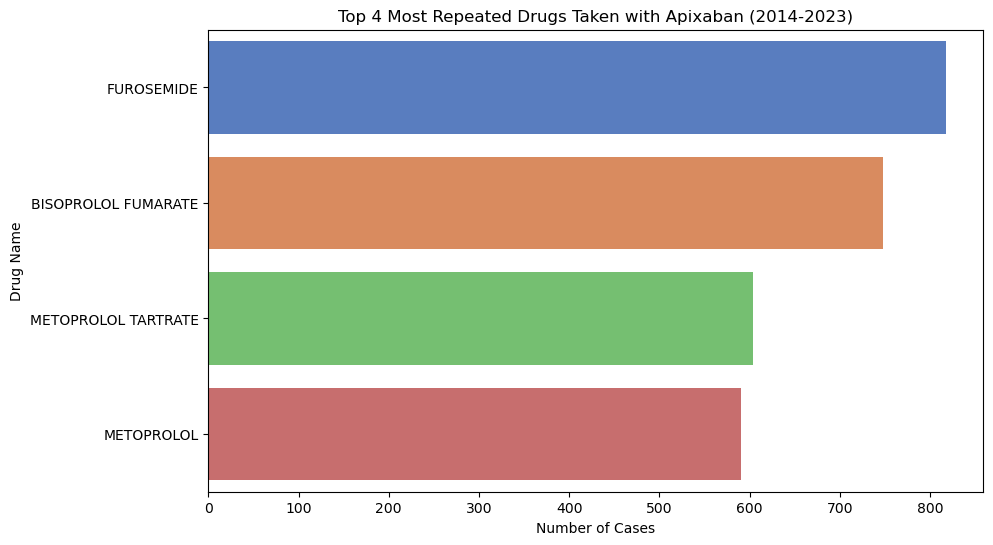

In [214]:
drug_counts = {
    "FUROSEMIDE": 818,
    "BISOPROLOL FUMARATE": 748,
    "METOPROLOL TARTRATE": 604,
    "METOPROLOL": 590
}

drug_df = pd.DataFrame(list(drug_counts.items()), columns=['Drug', 'Count'])

plt.figure(figsize=(10, 6))
sns.barplot(x='Count', y='Drug', data=drug_df, palette='muted')
plt.title('Top 4 Most Repeated Drugs Taken with Apixaban (2014-2023)')
plt.xlabel('Number of Cases')
plt.ylabel('Drug Name')
plt.show()


In [56]:
file_path = '/Users/sarvenaz/Desktop/Western Uni/Summer/Project/New/Apixaban_fReaction.csv'
df = pd.read_csv(file_path)

# Function to extract the generic names of drugs from the 'drugs_info' column
def extract_generic_names(drugs_info_str):
    try:
        drugs_info = ast.literal_eval(drugs_info_str)
        generic_names = []
        for drug in drugs_info:
            names = drug.get('generic_name', [])
            generic_names.extend(names)
        return generic_names
    except (ValueError, SyntaxError):
        return []

df['generic_names'] = df['drugs_info'].apply(extract_generic_names)

# Explode the 'generic_names' column to get one drug per row
drugs_exploded = df.explode('generic_names')
drugs_filtered = drugs_exploded[drugs_exploded['generic_names'].str.upper() != 'APIXABAN']

drug_counts = drugs_filtered['generic_names'].value_counts().head(4)

print("Top 4 Most Repeated Drugs Taken with Apixaban in 10 Years WITH Reaction Filter:")
print(drug_counts.to_string())


Top 4 Most Repeated Drugs Taken with Apixaban in 10 Years WITH Reaction Filter:
METOPROLOL TARTRATE    105
METOPROLOL             100
BISOPROLOL FUMARATE     95
FUROSEMIDE              80


In [75]:
file_path = '/Users/sarvenaz/Desktop/Western Uni/Summer/Project/New/Apixaban_fReaction.csv'
df = pd.read_csv(file_path)

df['reaction'] = df['reaction'].apply(ast.literal_eval)

# Create a set of all unique reactions
unique_reactions = set(reaction for sublist in df['reaction'] for reaction in sublist)

# Create a column for each unique reaction with one-hot encoding
for reaction in unique_reactions:
    df[reaction] = df['reaction'].apply(lambda x: 1 if reaction in x else 0)

df = df.drop(columns=['reaction'])

print(df.head())
df.to_csv('/Users/sarvenaz/Desktop/Western Uni/Summer/Project/New/Apixaban_reactions_binary.csv', index=False)

   safetyreportid  receivedate  patientsex  patientage  patientweight  \
0         9913345     20140218         1.0        78.0           92.0   
1        10283120     20140702         2.0        86.0           62.2   
2        10510049     20141009         2.0        78.0           80.5   
3        10542583     20141023         1.0        82.0           67.5   
4        10579468     20141112         1.0        69.0            NaN   

  reactionoutcome                                         drugs_info  \
0          [None]  [{'generic_name': ['APIXABAN'], 'drugcharacter...   
1          [None]  [{'generic_name': ['APIXABAN'], 'drugcharacter...   
2          [None]  [{'generic_name': [], 'drugcharacterization': ...   
3          [None]  [{'generic_name': ['APIXABAN'], 'drugcharacter...   
4      ['1', '6']  [{'generic_name': [], 'drugcharacterization': ...   

   Cerebrovascular accident  Thrombosis  Atrial fibrillation  Cardiac disorder  
0                         0           0        

In [78]:
file_path = '/Users/sarvenaz/Desktop/Western Uni/Summer/Project/New/Apixaban_reactions_binary.csv'
df = pd.read_csv(file_path)

def extract_generic_names(drug_info):
    try:
        drug_list = ast.literal_eval(drug_info)
        generic_names = []
        for drug in drug_list:
            names = drug.get('generic_name', [])
            if isinstance(names, list):
                for name in names:
                    if 'APIXABAN' not in name.upper():
                        generic_names.append(name)
        return generic_names
    except:
        return []

# Apply the function to the 'drugs_info' column to get a list of all generic names
df['generic_names'] = df['drugs_info'].apply(extract_generic_names)

df_exploded = df.explode('generic_names')

top_4_drugs = df_exploded['generic_names'].value_counts().head(4).index.tolist()

# Create a column for each of the top 4 drugs with one-hot encoding and the specific column naming format
for drug in top_4_drugs:
    interaction_column = f'interaction_APIXABAN_{drug}'
    df[interaction_column] = df['generic_names'].apply(lambda x: 1 if drug in x else 0)

df = df.drop(columns=['generic_names'])
print(df.head())
df.to_csv('/Users/sarvenaz/Desktop/Western Uni/Summer/Project/New/Apixaban_reactions_drugs_binary.csv', index=False)

   safetyreportid  receivedate  patientsex  patientage  patientweight  \
0         9913345     20140218         1.0        78.0           92.0   
1        10283120     20140702         2.0        86.0           62.2   
2        10510049     20141009         2.0        78.0           80.5   
3        10542583     20141023         1.0        82.0           67.5   
4        10579468     20141112         1.0        69.0            NaN   

  reactionoutcome                                         drugs_info  \
0          [None]  [{'generic_name': ['APIXABAN'], 'drugcharacter...   
1          [None]  [{'generic_name': ['APIXABAN'], 'drugcharacter...   
2          [None]  [{'generic_name': [], 'drugcharacterization': ...   
3          [None]  [{'generic_name': ['APIXABAN'], 'drugcharacter...   
4      ['1', '6']  [{'generic_name': [], 'drugcharacterization': ...   

   Cerebrovascular accident  Thrombosis  Atrial fibrillation  \
0                         0           0                    0   


In [82]:
# Load the CSV file
file_path = '/Users/sarvenaz/Desktop/Western Uni/Summer/Project/New/Apixaban_reactions_drugs_binary.csv'
df = pd.read_csv(file_path)

# Function to extract relevant drug information for the top 4 drugs
def extract_drug_info(drug_info, top_4_drugs):
    try:
        drug_list = ast.literal_eval(drug_info)
        drug_data = []
        for drug in drug_list:
            names = drug.get('generic_name', [])
            if isinstance(names, list):
                for name in names:
                    if name in top_4_drugs:
                        drug_info_entry = {
                            'generic_name': name,
                            'drugcharacterization': drug.get('drugcharacterization', 'None'),
                            'drugdosageform': drug.get('drugdosageform', 'None'),
                            'drugadministrationroute': drug.get('drugadministrationroute', 'None'),
                            'drugstructuredosagenumb': drug.get('drugstructuredosagenumb', 'None'),
                            'drugstructuredosageunit': drug.get('drugstructuredosageunit', 'None')
                        }
                        drug_data.append(drug_info_entry)
        return drug_data
    except:
        return []

# Reuse the top 4 drugs identified earlier
top_4_drugs = ['METOPROLOL TARTRATE', 'METOPROLOL', 'BISOPROLOL FUMARATE', 'FUROSEMIDE']  # Replace with actual top 4 if different

# Extract the relevant drug information for each record
df['top_4_drug_info'] = df['drugs_info'].apply(lambda x: extract_drug_info(x, top_4_drugs))

# Explode the dataframe to have one row per drug per safetyreportid
df_exploded_drugs = df.explode('top_4_drug_info')

# Convert the exploded dictionary column into separate columns
drug_info_df = pd.json_normalize(df_exploded_drugs['top_4_drug_info'])

# Reset the index to avoid concatenation issues
df_exploded_drugs.reset_index(drop=True, inplace=True)
drug_info_df.reset_index(drop=True, inplace=True)

# Concatenate the drug information back with the original dataframe
df_final = pd.concat([df_exploded_drugs.drop(columns=['top_4_drug_info']), drug_info_df], axis=1)

# Replace 'None' and 'Unknown' with NaN to treat them as missing values
df_final.replace(['None', 'Unknown'], pd.NA, inplace=True)

# Initialize a dictionary to store the missing value percentages
missing_value_percentages = {}

# Calculate missing value percentages for each of the top 4 drugs
for drug in top_4_drugs:
    df_drug = df_final[df_final['generic_name'] == drug]
    total_count = len(df_drug)
    missing_percentage = df_drug.isna().mean() * 100
    missing_value_percentages[drug] = missing_percentage[['drugcharacterization', 'drugdosageform', 'drugadministrationroute', 'drugstructuredosagenumb', 'drugstructuredosageunit']]

# Display the missing value percentages for each drug
missing_value_percentages

{'METOPROLOL TARTRATE': drugcharacterization        0.000000
 drugdosageform             94.285714
 drugadministrationroute    14.285714
 drugstructuredosagenumb    70.476190
 drugstructuredosageunit    70.476190
 dtype: float64,
 'METOPROLOL': drugcharacterization        0.0
 drugdosageform             95.0
 drugadministrationroute    15.0
 drugstructuredosagenumb    72.0
 drugstructuredosageunit    72.0
 dtype: float64,
 'BISOPROLOL FUMARATE': drugcharacterization        0.000000
 drugdosageform             90.526316
 drugadministrationroute    10.526316
 drugstructuredosagenumb    27.368421
 drugstructuredosageunit    27.368421
 dtype: float64,
 'FUROSEMIDE': drugcharacterization        0.00
 drugdosageform             95.00
 drugadministrationroute     6.25
 drugstructuredosagenumb    57.50
 drugstructuredosageunit    57.50
 dtype: float64}

In [84]:
# Initialize a dictionary to store the values for 'drugcharacterization' and 'drugadministrationroute'
characterization_values = {}

# Extract 'drugcharacterization' and 'drugadministrationroute' for each of the top 4 drugs
for drug in top_4_drugs:
    df_drug = df_final[df_final['generic_name'] == drug]
    characterization_values[drug] = df_drug[['drugcharacterization', 'drugadministrationroute']].dropna().value_counts()

# Display the characterization and administration route values for each drug
characterization_values

{'METOPROLOL TARTRATE': drugcharacterization  drugadministrationroute
 2                     065                        86
                       048                         3
                       042                         1
 dtype: int64,
 'METOPROLOL': drugcharacterization  drugadministrationroute
 2                     065                        81
                       048                         3
                       042                         1
 dtype: int64,
 'BISOPROLOL FUMARATE': drugcharacterization  drugadministrationroute
 2                     065                        59
                       048                        26
 dtype: int64,
 'FUROSEMIDE': drugcharacterization  drugadministrationroute
 2                     065                        60
                       048                        13
                       042                         2
 dtype: int64}

In [86]:
# Load the CSV file
file_path = '/Users/sarvenaz/Desktop/Western Uni/Summer/Project/New/Apixaban_reactions_drugs_binary.csv'
df = pd.read_csv(file_path)

# Function to extract the relevant information from the 'drugs_info' field
def extract_drug_info(drug_info, top_4_drugs):
    try:
        drug_list = ast.literal_eval(drug_info)
        for drug in drug_list:
            names = drug.get('generic_name', [])
            if isinstance(names, list):
                for name in names:
                    if name in top_4_drugs:
                        return {
                            'generic_name': name,
                            'drugadministrationroute': drug.get('drugadministrationroute', 'None')
                        }
        return {'generic_name': None, 'drugadministrationroute': None}
    except:
        return {'generic_name': None, 'drugadministrationroute': None}

# Extract the relevant drug information for each record
df_drug_info = df['drugs_info'].apply(lambda x: extract_drug_info(x, top_4_drugs))

# Convert the extracted information into a DataFrame and join it with the original DataFrame
df_drug_info = pd.DataFrame(df_drug_info.tolist())
df = df.join(df_drug_info)

# Add one-hot encoded columns for drug administration routes 065 and 048 for each of the top 4 drugs
for drug in top_4_drugs:
    # Create columns for each route
    route_065_column = f'{drug}_drugadministrationroute_065'
    route_048_column = f'{drug}_drugadministrationroute_048'

    # One-hot encode the presence of each route
    df[route_065_column] = df.apply(lambda row: 1 if row['generic_name'] == drug and row['drugadministrationroute'] == '065' else 0, axis=1)
    df[route_048_column] = df.apply(lambda row: 1 if row['generic_name'] == drug and row['drugadministrationroute'] == '048' else 0, axis=1)

# Save the updated dataset to a new CSV file
output_path = '/Users/sarvenaz/Desktop/Western Uni/Summer/Project/New/Apixaban_reactions_drugs_routes_binary.csv'
df.to_csv(output_path, index=False)

output_path

'/Users/sarvenaz/Desktop/Western Uni/Summer/Project/New/Apixaban_reactions_drugs_routes_binary.csv'

In [87]:
# Load the new dataset
file_path = '/Users/sarvenaz/Desktop/Western Uni/Summer/Project/New/Apixaban_reactions_drugs_routes_binary.csv'
df = pd.read_csv(file_path)

# Define the drug of interest (Apixaban)
target_drug = 'APIXABAN'

# Function to extract relevant drug information for Apixaban
def extract_apixaban_info(drug_info):
    try:
        drug_list = ast.literal_eval(drug_info)
        for drug in drug_list:
            names = drug.get('generic_name', [])
            if isinstance(names, list) and target_drug in names:
                return {
                    'drugcharacterization': drug.get('drugcharacterization', 'None'),
                    'drugdosageform': drug.get('drugdosageform', 'None'),
                    'drugadministrationroute': drug.get('drugadministrationroute', 'None'),
                    'drugstructuredosagenumb': drug.get('drugstructuredosagenumb', 'None'),
                    'drugstructuredosageunit': drug.get('drugstructuredosageunit', 'None')
                }
        return {
            'drugcharacterization': None,
            'drugdosageform': None,
            'drugadministrationroute': None,
            'drugstructuredosagenumb': None,
            'drugstructuredosageunit': None
        }
    except:
        return {
            'drugcharacterization': None,
            'drugdosageform': None,
            'drugadministrationroute': None,
            'drugstructuredosagenumb': None,
            'drugstructuredosageunit': None
        }

# Extract the relevant drug information for Apixaban
df_apixaban_info = df['drugs_info'].apply(lambda x: extract_apixaban_info(x))

# Convert the extracted information into a DataFrame and join it with the original DataFrame
df_apixaban_info = pd.DataFrame(df_apixaban_info.tolist())

# Replace 'None' and 'Unknown' with NaN to treat them as missing values
df_apixaban_info.replace(['None', 'Unknown'], pd.NA, inplace=True)

# Calculate the percentage of missing data for each column related to Apixaban
missing_data_apixaban = df_apixaban_info.isna().mean() * 100

# Display the missing data percentages for Apixaban
missing_data_apixaban

drugcharacterization        0.000000
drugdosageform             92.503830
drugadministrationroute     1.149048
drugstructuredosagenumb    86.857080
drugstructuredosageunit    86.868024
dtype: float64

In [88]:
# Extract the unique values and their counts for 'drugadministrationroute' related to Apixaban
route_values_apixaban = df_apixaban_info['drugadministrationroute'].value_counts(dropna=False)

# Display the values and their counts for Apixaban's administration routes
route_values_apixaban

065     8277
048      754
None     105
005        2
Name: drugadministrationroute, dtype: int64

In [90]:
file_path = '/Users/sarvenaz/Desktop/Western Uni/Summer/Project/New/Apixaban_reactions_drugs_routes_binary.csv'
df = pd.read_csv(file_path)

# Extract the necessary information for Apixaban
df_apixaban_info = df['drugs_info'].apply(lambda x: extract_apixaban_info(x))
df_apixaban_info = pd.DataFrame(df_apixaban_info.tolist())

# Add one-hot encoded columns for Apixaban administration routes 065 and 048
df['Apixaban_drugadministrationroute_065'] = df_apixaban_info['drugadministrationroute'].apply(lambda x: 1 if x == '065' else 0)
df['Apixaban_drugadministrationroute_048'] = df_apixaban_info['drugadministrationroute'].apply(lambda x: 1 if x == '048' else 0)

df = df.drop(columns=['drugs_info', 'generic_name', 'drugadministrationroute', 'reactionoutcome'])

output_path = '/Users/sarvenaz/Desktop/Western Uni/Summer/Project/New/Apixaban_reactions_drugs_allroutes_binary.csv'
df.to_csv(output_path, index=False)

output_path

'/Users/sarvenaz/Desktop/Western Uni/Summer/Project/New/Apixaban_reactions_drugs_allroutes_binary.csv'

In [215]:
file_path = '/Users/sarvenaz/Desktop/Western Uni/Summer/Project/New/Apixaban_reactions_drugs_allroutes_binary.csv'
df = pd.read_csv(file_path)

missing_data_percentage = df.isna().mean() * 100
missing_data_specific = missing_data_percentage[['patientsex', 'patientweight']]

# Display the missing data percentages for these specific columns
print(missing_data_specific)

patientsex        3.556577
patientweight    95.239659
dtype: float64


In [98]:
file_path = '/Users/sarvenaz/Desktop/Western Uni/Summer/Project/New/Apixaban_reactions_drugs_allroutes_binary.csv'
df = pd.read_csv(file_path)

# Select the features for predicting age
features = ['patientsex', 'patientweight', 'Cerebrovascular accident', 'Thrombosis', 
            'Atrial fibrillation', 'Cardiac disorder', 'interaction_APIXABAN_METOPROLOL TARTRATE', 
            'interaction_APIXABAN_METOPROLOL', 'interaction_APIXABAN_BISOPROLOL FUMARATE', 
            'interaction_APIXABAN_FUROSEMIDE', 'Apixaban_drugadministrationroute_065', 
            'Apixaban_drugadministrationroute_048']

df_filtered = df[['safetyreportid'] + features + ['patientage']]

train_data = df_filtered.dropna(subset=['patientage'])
test_data = df_filtered[df_filtered['patientage'].isna()].copy()

X_train = train_data[features]
y_train = train_data['patientage']

# Impute missing values in the features for model training
imputer = SimpleImputer(strategy='median')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(test_data[features])

# Train a Random Forest Regressor on the non-missing age data with imputed features
model = RandomForestRegressor(n_estimators=100, random_state=7)
model.fit(X_train_imputed, y_train)

# Use the model to predict the missing ages
predicted_ages = model.predict(X_test_imputed)
test_data.loc[:, 'patientage'] = predicted_ages

# Combine the training data with the test data that now has predicted ages
df_combined = pd.concat([train_data, test_data])

# Handling outliers by capping the minimum age at 18 and maximum age at 100
df_combined['patientage'] = df_combined['patientage'].clip(lower=18, upper=100)

# Re-add the safetyreportid to the original dataset for mapping
df_original = pd.read_csv(file_path)  
df_imputed_with_id = df_combined[['safetyreportid', 'patientage']]  
df_final = pd.merge(df_original, df_imputed_with_id, on='safetyreportid', how='left', suffixes=('', '_imputed'))
df_final['patientage'] = df_final['patientage_imputed']
df_final.drop(columns=['patientage_imputed'], inplace=True)

output_path = '/Users/sarvenaz/Desktop/Western Uni/Summer/Project/New/Apixaban_reactions_drugs_allroutes_binary_age.csv'
df_final.to_csv(output_path, index=False)

print(f"Final dataset with imputed ages and safetyreportid saved to: {output_path}")

Final dataset with imputed ages and safetyreportid saved to: /Users/sarvenaz/Desktop/Western Uni/Summer/Project/New/Apixaban_reactions_drugs_allroutes_binary_age.csv


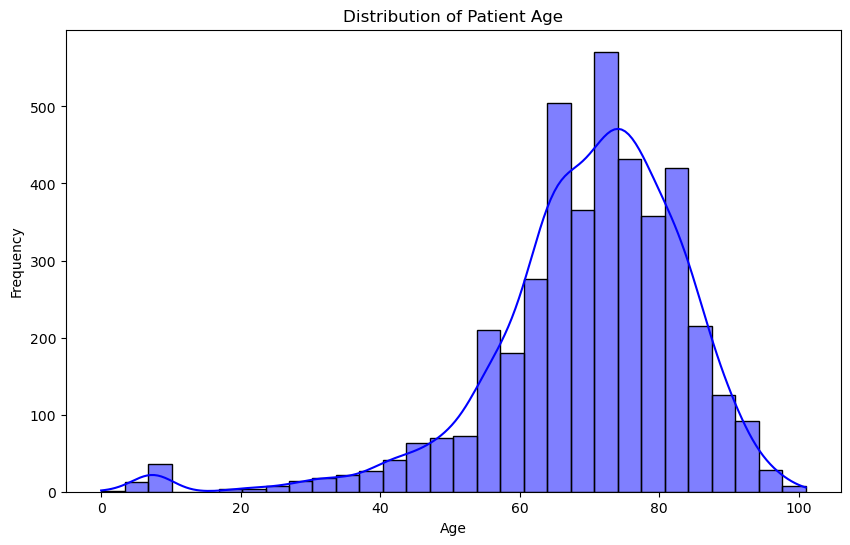

In [221]:
# Plotting the distribution of patient age
plt.figure(figsize=(10, 6))
sns.histplot(df['patientage'], bins=30, kde=True, color='blue')
plt.title('Distribution of Patient Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

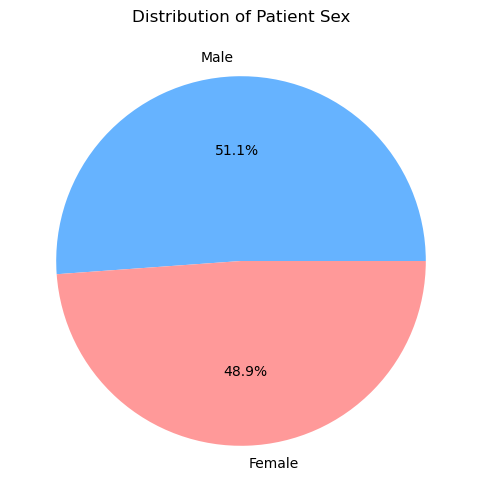

In [224]:
# Plotting the distribution of patient sex
plt.figure(figsize=(6, 6))
df['patientsex'].value_counts().plot.pie(autopct='%1.1f%%', colors=['#66b3ff','#ff9999'], labels=['Male', 'Female'])
plt.title('Distribution of Patient Sex')
plt.ylabel('') 
plt.show()

In [104]:
file_path = '/Users/sarvenaz/Desktop/Western Uni/Summer/Project/New/Apixaban_reactions_drugs_allroutes_binary_age.csv'
df = pd.read_csv(file_path)

sex_distribution = df['patientsex'].value_counts(normalize=True) * 100
sex_distribution

1.0    51.140361
2.0    48.859639
Name: patientsex, dtype: float64

In [107]:
# Fill missing patientsex values with the mode (most common value)
df['patientsex'].fillna(df['patientsex'].mode()[0], inplace=True)

df = df.drop(columns=['patientweight'])

output_path = '/Users/sarvenaz/Desktop/Western Uni/Summer/Project/New/Apixaban_reactions_drugs_allroutes_binary_filled_age_sex.csv'
df.to_csv(output_path, index=False)
print(f"Updated dataset with filled patient sex saved to: {output_path}")

Updated dataset with filled patient sex saved to: /Users/sarvenaz/Desktop/Western Uni/Summer/Project/New/Apixaban_reactions_drugs_allroutes_binary_filled_age_sex.csv


In [108]:
file_path = '/Users/sarvenaz/Desktop/Western Uni/Summer/Project/New/Apixaban_reactions_drugs_allroutes_binary_filled_age_sex.csv'
df = pd.read_csv(file_path)

# Create one-hot encoded columns for 'patientsex'
df['sex_1'] = (df['patientsex'] == 1).astype(int)
df['sex_2'] = (df['patientsex'] == 2).astype(int)

df = df.drop(columns=['patientsex'])

output_path = '/Users/sarvenaz/Desktop/Western Uni/Summer/Project/New/Apixaban_reactions_drugs_allroutes_sex_binary_filled_age_sex.csv'
df.to_csv(output_path, index=False)
output_path

'/Users/sarvenaz/Desktop/Western Uni/Summer/Project/New/Apixaban_reactions_drugs_allroutes_sex_binary_filled_age_sex.csv'

In [109]:
file_path = '/Users/sarvenaz/Desktop/Western Uni/Summer/Project/New/Apixaban_reactions_drugs_allroutes_sex_binary_filled_age_sex.csv'
df = pd.read_csv(file_path)

# Define the target variables for each reaction
target_columns = ['Cerebrovascular accident', 'Thrombosis', 'Atrial fibrillation', 'Cardiac disorder']

# Group features based on patient characteristics, Apixaban-specific data, and interacting drugs
# Patient features
patient_features = ['patientage', 'sex_1', 'sex_2']

# Apixaban-specific features (columns starting with 'Apixaban')
apixaban_features = [col for col in df.columns if col.startswith('Apixaban')]

# Interacting drugs features (columns starting with 'interaction_APIXABAN_')
interaction_drug_features = [col for col in df.columns if col.startswith('interaction_APIXABAN_')]

# Drug administration routes related to the interacting drugs
drug_route_features = [col for col in df.columns if '_drugadministrationroute_' in col]

# Combine all features
all_features = patient_features + apixaban_features + interaction_drug_features + drug_route_features

# Prepare the feature matrix (X) and target vector (y)
X = df[all_features]
y = df[target_columns]

# Check the prepared features and targets
X.head(), y.head()


(   patientage  sex_1  sex_2  Apixaban_drugadministrationroute_065  \
 0        78.0      1      0                                     0   
 1        86.0      0      1                                     0   
 2        78.0      0      1                                     0   
 3        82.0      1      0                                     0   
 4        69.0      1      0                                     0   
 
    Apixaban_drugadministrationroute_048  \
 0                                     1   
 1                                     1   
 2                                     1   
 3                                     1   
 4                                     1   
 
    interaction_APIXABAN_METOPROLOL TARTRATE  interaction_APIXABAN_METOPROLOL  \
 0                                         0                                0   
 1                                         0                                0   
 2                                         0                         

In [256]:
file_path = '/Users/sarvenaz/Desktop/Western Uni/Summer/Project/New/Apixaban_reactions_drugs_allroutes_sex_binary_filled_age_sex.csv'
df = pd.read_csv(file_path)

# Drop unnecessary columns
df = df.drop(columns=['safetyreportid', 'receivedate'])

# Define target columns
targets = ['Cerebrovascular accident', 'Thrombosis', 'Atrial fibrillation', 'Cardiac disorder']

best_models = {}
best_scores = {}

# Train and evaluate a model for each target condition
for target in targets:
    print(f"Training and tuning model for {target} considering other targets as features...")
    
    X = df.drop(columns=[target])
    y = df[target]
    
    feature_names = X.columns
    
    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
    
    # Standardize the feature set
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # Apply SMOTE to handle class imbalance
    smote = SMOTE(random_state=123)
    X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
    
    # Define the parameter grid for Random Forest
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'bootstrap': [True, False]
    }
    
    # Initialize Random Forest and GridSearchCV
    rf = RandomForestClassifier(random_state=123)
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=2)
    
    grid_search.fit(X_resampled, y_resampled)
    
    best_models[target] = grid_search.best_estimator_
    best_scores[target] = grid_search.best_score_
    
    print(f"Best parameters for {target}: {grid_search.best_params_}")
    print(f"Best cross-validated F1 score for {target}: {grid_search.best_score_:.2f}")
    
    # Make predictions
    y_pred = grid_search.best_estimator_.predict(X_test)
    y_pred_proba = grid_search.best_estimator_.predict_proba(X_test)
    
    # Calculate accuracy, log loss, and brier score
    accuracy = accuracy_score(y_test, y_pred)
    loss_log = log_loss(y_test, y_pred_proba)
    loss_brier = brier_score_loss(y_test, y_pred_proba[:, 1])
    
    report = classification_report(y_test, y_pred)
    
    print(f"Accuracy for {target}: {accuracy:.2f}")
    print(f"Log Loss for {target}: {loss_log:.4f}")
    print(f"Brier Score for {target}: {loss_brier:.4f}")
    print(f"Classification Report for {target}:\n{report}")


Training and tuning model for Cerebrovascular accident considering other targets as features...
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best parameters for Cerebrovascular accident: {'bootstrap': True, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Best cross-validated F1 score for Cerebrovascular accident: 0.98
Accuracy for Cerebrovascular accident: 0.98
Log Loss for Cerebrovascular accident: 0.1508
Brier Score for Cerebrovascular accident: 0.0192
Classification Report for Cerebrovascular accident:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1233
           1       0.99      0.95      0.97       595

    accuracy                           0.98      1828
   macro avg       0.98      0.97      0.98      1828
weighted avg       0.98      0.98      0.98      1828

Training and tuning model for Thrombosis considering other targets as features...
Fitting 5 folds for each

Feature importance for Cerebrovascular accident considering other targets as features...


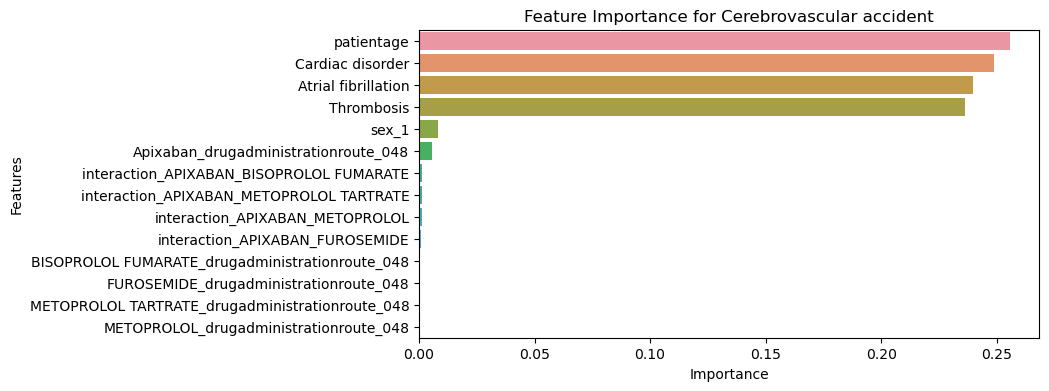

Feature importance for Thrombosis considering other targets as features...


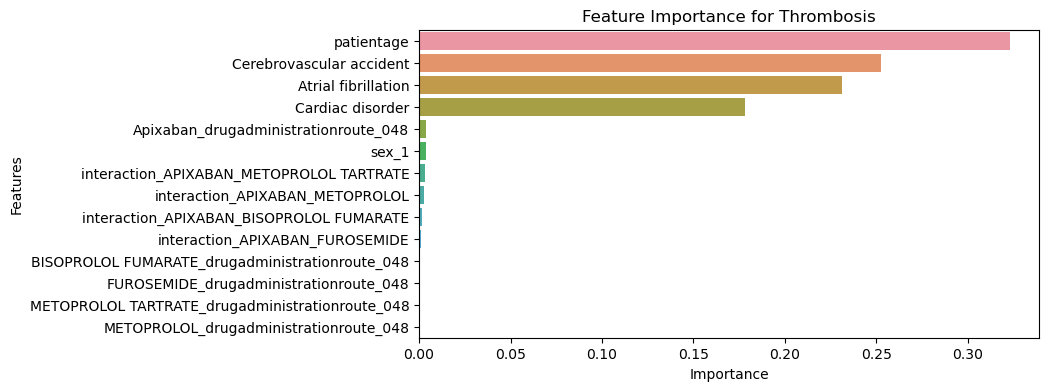

Feature importance for Atrial fibrillation considering other targets as features...


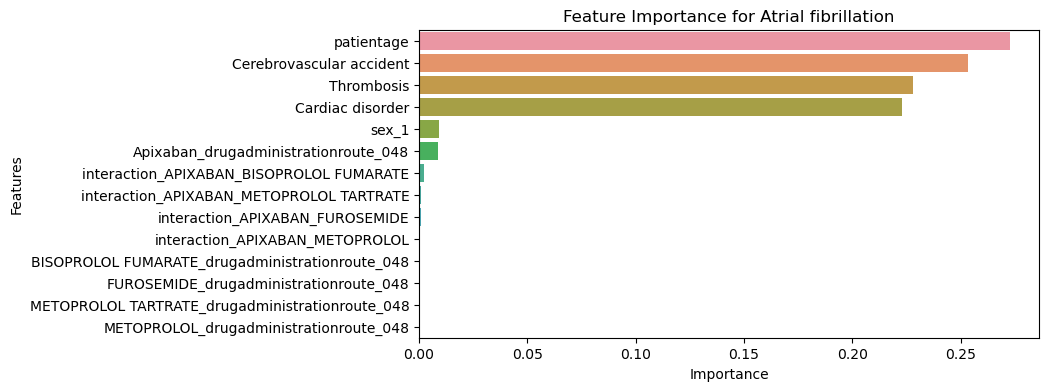

Feature importance for Cardiac disorder considering other targets as features...


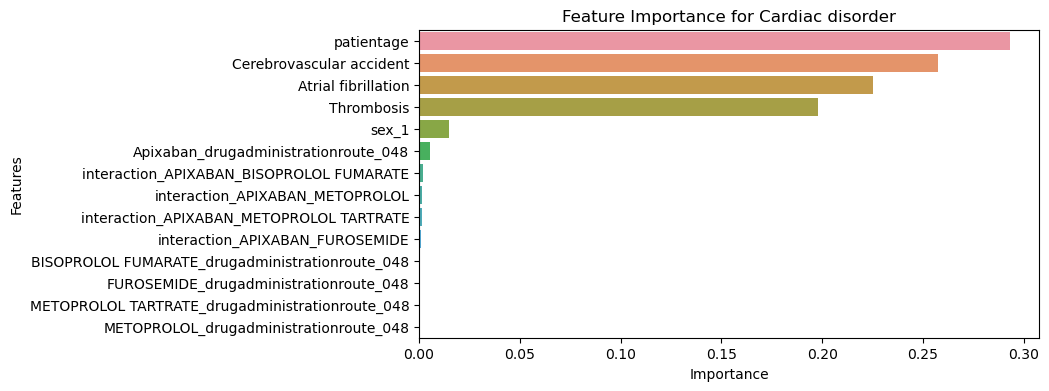

[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   1.5s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.7s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   0.9s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=   0.9s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.5s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.5s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_

[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.9s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.7s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.6s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, mi

[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.8s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   1.4s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   1.0s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.6s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   0.8s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.6s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_

[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.7s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.6s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.7s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.7s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=   0.9s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   0.8s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, mi

[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.7s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   1.4s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   1.0s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.6s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.6s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   0.8s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.8s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_

In [261]:
# Plot the feature importance

for target in targets:
    print(f"Feature importance for {target} considering other targets as features:")
    best_model = best_models[target]
    importances = best_model.feature_importances_
    
    feature_names = [col for col in df.columns if col != target]
    indices = np.argsort(importances)[::-1]
    
    plt.figure(figsize=(8, 4))
    sns.barplot(x=importances[indices], y=[feature_names[i] for i in indices])
    plt.title(f"Feature Importance for {target}")
    plt.xlabel('Importance')
    plt.ylabel('Features')
    plt.show()


Training and tuning model for Cerebrovascular accident considering other targets as features:


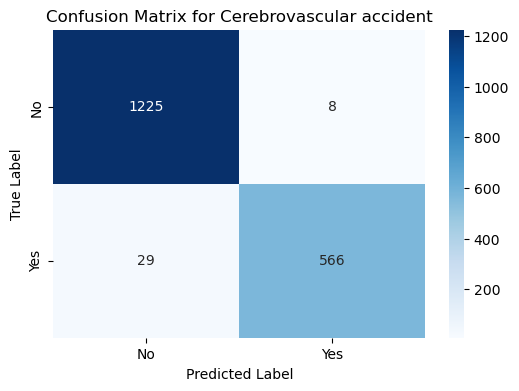

Training and tuning model for Thrombosis considering other targets as features:


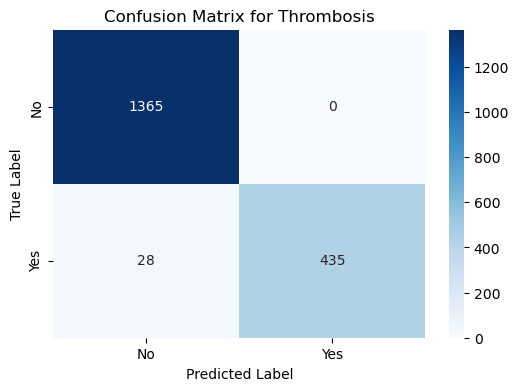

Training and tuning model for Atrial fibrillation considering other targets as features:


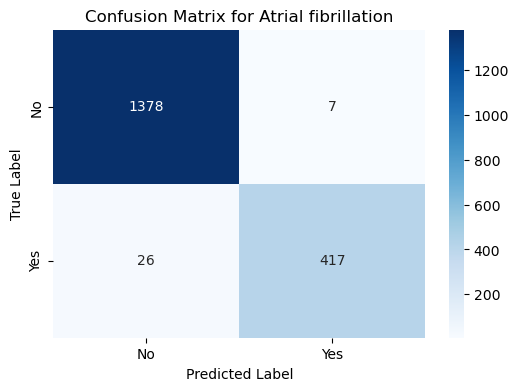

Training and tuning model for Cardiac disorder considering other targets as features:


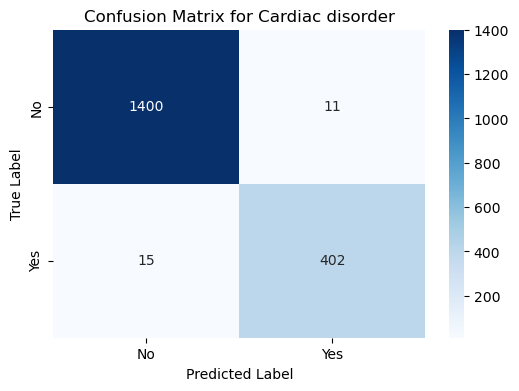

In [265]:
# Plot the confusion matrix

for target in targets:
    print(f"Training and tuning model for {target} considering other targets as features:")
    
    X = df.drop(columns=[target])
    y = df[target]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    smote = SMOTE(random_state=123)
    X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
    
    best_model = best_models[target]
    y_pred = best_model.predict(X_test)
    
    # Generate the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Plot the confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
    plt.title(f'Confusion Matrix for {target}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()


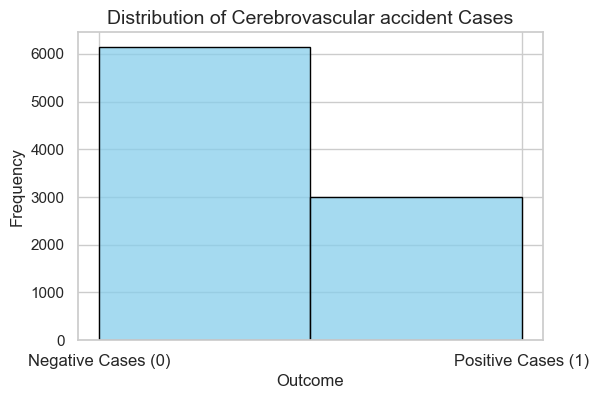

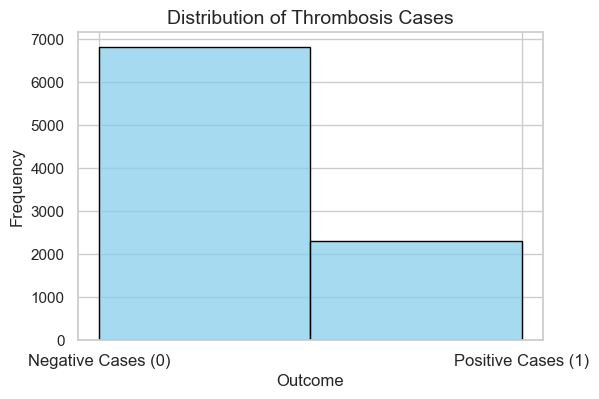

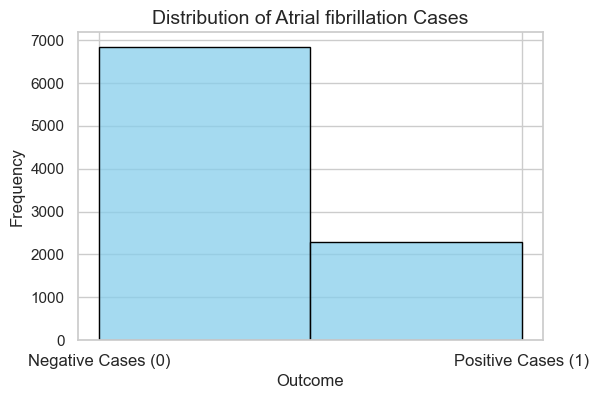

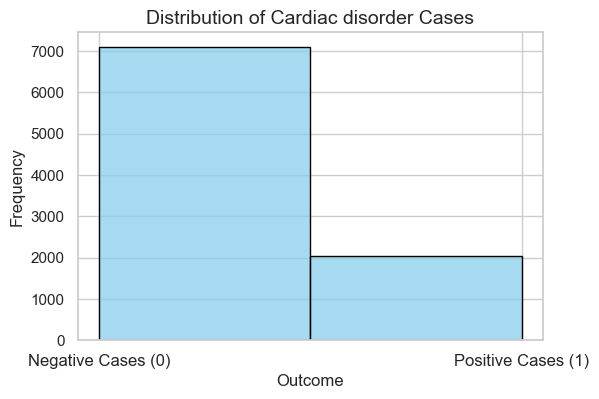

In [276]:
# Visualize the distribution of the outcome variables
sns.set(style="whitegrid")
for target in targets:
    plt.figure(figsize=(6, 4))    
    sns.histplot(df[target], bins=2, kde=False, color='skyblue', edgecolor='black')
    plt.title(f'Distribution of {target} Cases', fontsize=14)
    plt.xlabel('Outcome', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)    
    plt.xticks([0, 1], ['Negative Cases (0)', 'Positive Cases (1)'], fontsize=12)    
    plt.grid(True)    
    plt.show()